In [2]:
#%pip install geopandas
#%pip install folium
#%pip install rasterio
#%pip install rioxarray
#%pip install geojson
#%pip install gdal
#%pip install sentinelsat
#%pip install utm

#%%capture
# !apt update
# !apt install -y software-properties-common
# !apt install -y gpg
# !add-apt-repository -y ppa:ubuntugis/ppa && apt-get update
# !add-apt-repository -y ppa:nextgis/ppa && apt-get update 
# !apt-get install -y gdal-bin
# !apt-get install -y libgdal-dev pgp
# !export CPLUS_INCLUDE_PATH=/usr/include/gdal
# !export C_INCLUDE_PATH=/usr/include/gdal
# !apt-get install -y --reinstall build-essential
# !pip3 install "setuptools<58"
# !pip3 install --global-option=build_ext --global-option="-I/usr/include/gdal" GDAL==`gdal-config --version`

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.prepared import prep
import timeit
import shutil
from tqdm import tqdm
import rasterio
from rasterio.plot import show_hist
from rasterio.plot import show
from rasterio.windows import Window
import utm
import pyproj
import os
import folium
import pandas as pd
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import ujson
from osgeo import gdal
import time

from sentinel2_transform import UTM2LonLat

In [3]:
# Set session and s3 connection objects
sess = sagemaker.Session()
role = get_execution_role()
conn = boto3.client("s3")
bucket = "w210-poverty-mapper"
s3_load_path = "sentinel2_composite/raw_data"
s3_save_path = "sentinel2_composite/transformed_data"

In [4]:
# Example Bangladesh file
bd_test = rasterio.open("s3://w210-poverty-mapper/sentinel2_composite/raw_data/45R/S2_percentile_30_UTM_404-0000000000-0000000000.tif")

# Example Timor Leste file
tl_test = rasterio.open("s3://w210-poverty-mapper/sentinel2_composite/raw_data/51L/S2_percentile_UTM_710-0000000000-0000000000.tif")

In [5]:
# Check crs 
bd_zone_list = ["45R", "45Q", "46R", "46Q"]
np_zone_list = ['44R']

bd_epsg = []
np_epsg = []

for zone in bd_zone_list:
        #print("Zone: {}".format(zone))
        contents = conn.list_objects(
            Bucket=bucket, 
            Prefix="sentinel2_composite/raw_data/" + zone)["Contents"]
        
        for file in contents:
            if file["Key"].endswith(".tif"):
                #print(file["Key"])
                img = rasterio.open("s3://w210-poverty-mapper/" + file["Key"])
                bd_epsg.append(img.crs)
                
                
for zone in np_zone_list:
        #print("Zone: {}".format(zone))
        contents = conn.list_objects(
            Bucket=bucket, 
            Prefix="sentinel2_composite/raw_data/" + zone)["Contents"]
        
        for file in contents:
            if file["Key"].endswith(".tif"):
                #print(file["Key"])
                img = rasterio.open("s3://w210-poverty-mapper/" + file["Key"])
                np_epsg.append(img.crs)
                
print(set(bd_epsg))
print(set(np_epsg))

{CRS.from_epsg(32645)}
{CRS.from_epsg(32644)}


In [6]:
bd_test.transform
print(bd_test.height/224.0, bd_test.width/224.0)
print(tl_test.height, tl_test.width)

print(bd_test.bounds)
print((2887180.0 - 2654220.0)/1000)

utm = UTM2LonLat(bd_test)
print(utm.index_to_lon_lat(0, 0))
print(utm.index_to_lon_lat(bd_test.width, 0))
print(utm.index_to_lon_lat(0, bd_test.height))
print(utm.index_to_lon_lat(bd_test.width, bd_test.height))

104.0 104.0
23296 23296
BoundingBox(left=194770.0, bottom=2654220.0, right=427730.0, top=2887180.0)
232.96
(83.94910925871535, 26.07153787683023)
(86.27724741142355, 26.10199703138252)
(84.00065387726951, 23.970606319013072)
(86.28947953691599, 23.998294755935376)


In [7]:
# Check tif bounding boxes
zone_list = ["42S", "42T", "43S"]
#zone_list = ["45R", "46R", "45Q", "46Q"]
#zone_list = ["52N"]
#zone_list = ["50N", "50P", "50Q", "51N"]

contents  = []
for zone in zone_list:
    contents += conn.list_objects(
        Bucket=bucket, 
        Prefix="sentinel2_composite/raw_data/" + zone)["Contents"]

m = folium.Map([24, 90], zoom_start=3)

for file in contents:
    #print(file["Key"])
    if file["Key"].endswith(".tif"):
        #print(file["Key"])
        img = rasterio.open("s3://w210-poverty-mapper/" + file["Key"])
        utm = UTM2LonLat(img)
        #print(utm.get_zone())
        #print(utm.get_transform())
        #print(img.transform)
        #print(img.width, img.height)
        out = img.lnglat()
        folium.Marker(list(reversed(out)), popup="", tooltip=[file["Key"]]).add_to(m)
        
        points = [list(reversed(utm.index_to_lon_lat(lat, lon))) for (lat, lon) in [[0, 0], [0, img.height], [img.width, img.height], [img.width, 0], [0, 0]]]
        folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
m

In [8]:
# Check 224x224 image tiles
img_list = ["45R_404-0000023296-0000000000_00104_00080.tif",
            "45R_404-0000023296-0000000000_00104_00079.tif",
            "45R_404-0000023296-0000000000_00104_00078.tif",
            "45R_404-0000023296-0000000000_00104_00077.tif"]

for img in img_list:
    img_tile = rasterio.open("/root/tiles/45R/404-0000023296-0000000000/{}".format(img))

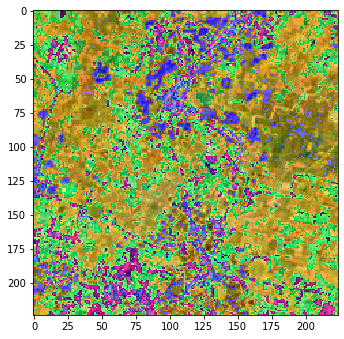

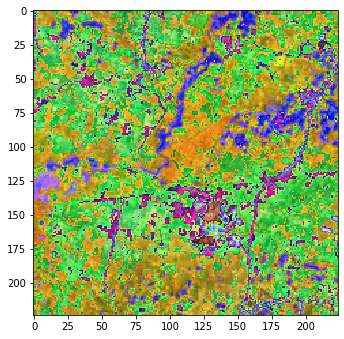

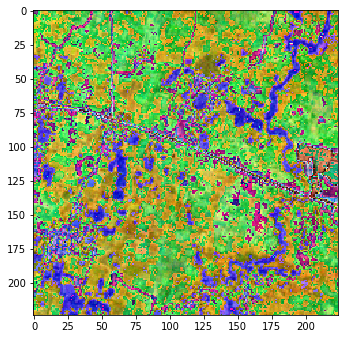

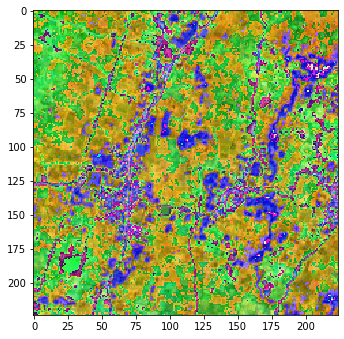

In [9]:
# Check 224x224 image tiles (different way of plotting)
for img in img_list:
    img_tile = rasterio.open("/root/tiles/45R/404-0000023296-0000000000/{}".format(img))
    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(img_tile.read().transpose(1, 2, 0).astype("uint8"))

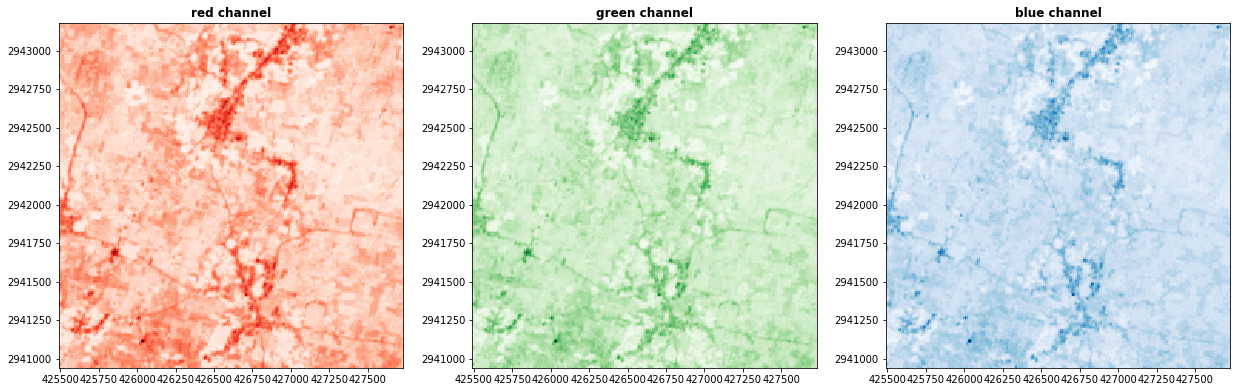

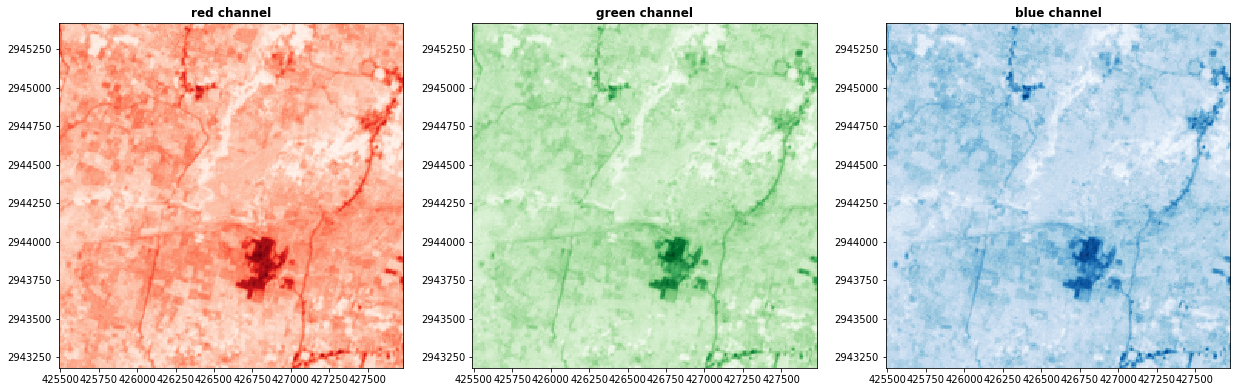

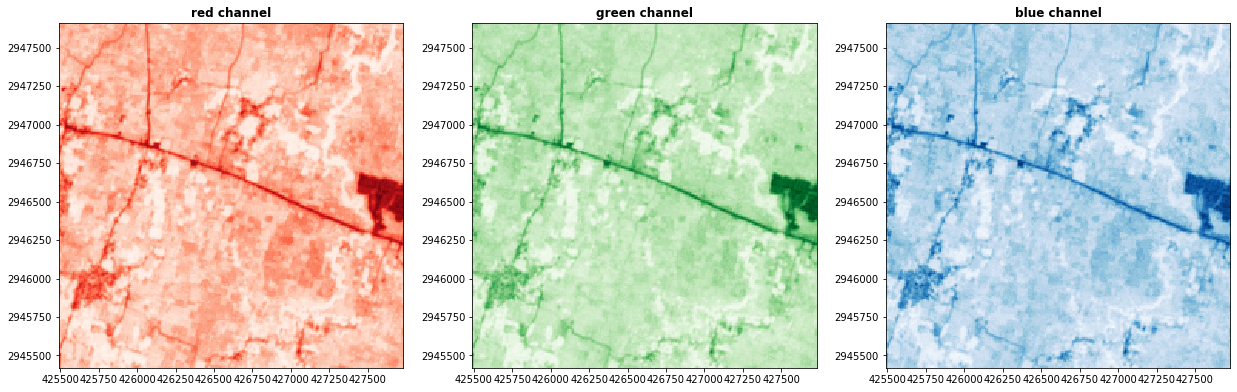

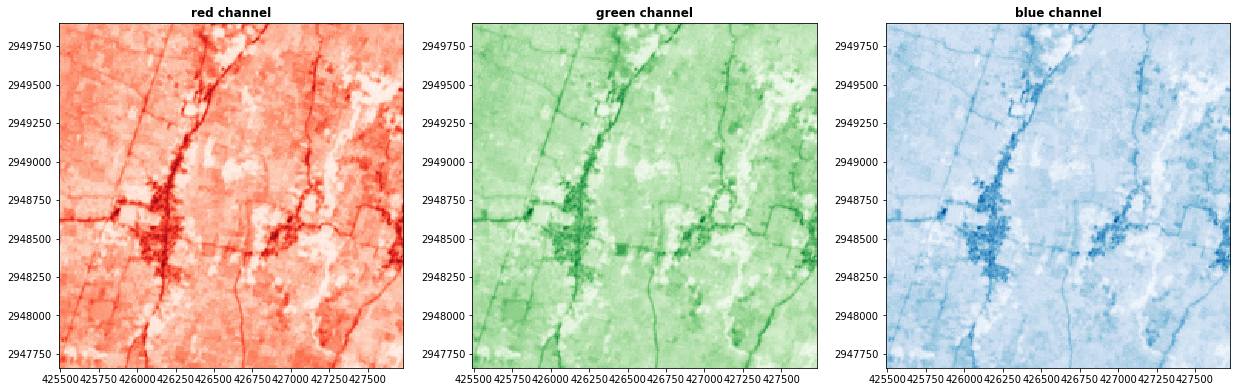

In [10]:
# Check band plotting for 224x224 images
for img in img_list:
    img_tile = rasterio.open("/root/tiles/45R/404-0000023296-0000000000/{}".format(img))
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    show((img_tile, 1), ax=axr, cmap='Reds', title='red channel')
    show((img_tile, 2), ax=axg, cmap='Greens', title='green channel')
    show((img_tile, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()


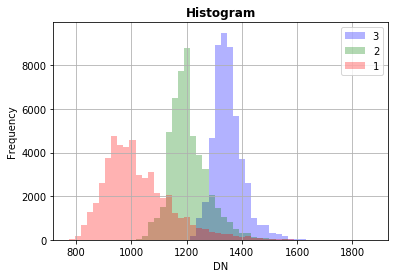

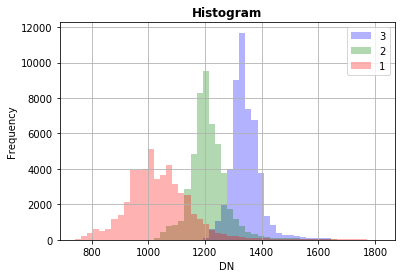

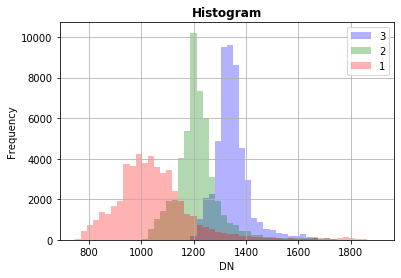

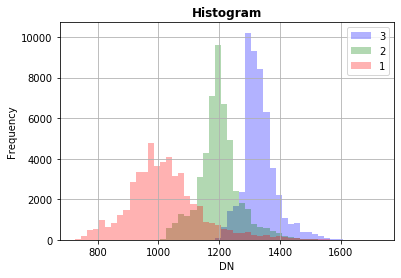

In [11]:
# Check histograms for 224x224 images 
for img in img_list:
    img_tile = rasterio.open("/root/tiles/45R/404-0000023296-0000000000/{}".format(img))
    show_hist(
        img_tile, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

In [12]:
counts = []

for zone in bd_zone_list:
    meta = pd.read_csv("/root/tiles/" + zone + "/meta_data_" + zone + ".csv")
    print(zone)
    print(meta.shape)
    counts.append(meta.shape[0])
    
print(sum(counts))

45R
(21683, 7)
45Q
(5672, 7)
46R
(5629, 7)
46Q
(9874, 7)
42858
